In [1]:
#!pip install tqdm
#! pip install kaggle

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from skimage.io import imshow
import tensorflow.keras.utils as np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import img_to_array , to_categorical
from tensorflow.keras import layers, models
from imutils import paths
import random
import os

Para baixar o dataset, usaremos o seguinte [vídeo](https://www.youtube.com/watch?v=yEXkEUqK52Q) como base.

Primeiramente, monte o drive e execute os comandos abaixo para colocar a chave da API kaggle na pasta local.

In [2]:
#from google.colab import drive
#drive.mount("/content/drive")

Agora, iremos criar uma pasta chamada kaggle e mudar sua permissão, assim, após copiarmos o arquivo .json, que contém a chave, poderemos usar localmente de forma segura.

In [3]:
#! mkdir ~/.kaggle
#! cp /content/drive/MyDrive/ColabNotebooks/data/kaggle.json ~/.kaggle/kaggle.json
#! chmod 600 ~/.kaggle/kaggle.json

Basta agora baixar o dataset em [kaggle](https://www.kaggle.com/) e passar os os diretórios de emoções que não interessam para outra pasta.


In [4]:

#! kaggle datasets download thienkhonghoc/affectnet --unzip
#! mkdir ugh
#! ls
#! mv AffectNet/train/1 AffectNet/train/2 AffectNet/train/7 ugh



- 0 -> Irritação
- 3 -> Felicidade
- 4 -> Tristeza
- 5 -> Surpresa
- 6 -> Neutralidade

Finalmente, iremos agora criar o modelo com o dataset:

In [5]:
def numtoemotion(a):
    match a:
      case 0:
        return "Irritação"
      case 3:
        return "Felicidade"
      case 4:
        return "Tristeza"
      case 5:
        return "Surpresa"
      case 6:
        return "Neutralidade"
      case _:
        return "Erro"

In [6]:
path_dataset = "./AffectNet/train"

label_dict = {}

#Carrega a lista de labels
for i, d in enumerate(sorted(os.listdir(path_dataset))):
    label_dict[d] = i
    print(label_dict[d]," - ",numtoemotion(label_dict[d]))


print("\n")
print("label_dict: ",label_dict)

#Calcula a quantidade de classes
num_classes = len(label_dict)

print("Número de classes: ", num_classes) # deve dar 5

# neutralidade(6),
# felicidade(3),
# irritação(0),
# surpresa(5)
# tristeza(4)


0  -  Irritação
1  -  Erro
2  -  Erro
3  -  Felicidade
4  -  Tristeza


label_dict:  {'0': 0, '3': 1, '4': 2, '5': 3, '6': 4}
Número de classes:  5


In [7]:
# grab the image paths and randomly shuffle them

imagePaths = sorted(list(paths.list_images(path_dataset)))
print("Verifique os seguintes caminhos: ", imagePaths[-5:])
random.seed(42)
random.shuffle(imagePaths)
#print(imagePaths)

Verifique os seguintes caminhos:  ['./AffectNet/train/6/image0017435.jpg', './AffectNet/train/6/image0017436.jpg', './AffectNet/train/6/image0017437.jpg', './AffectNet/train/6/image0017438.jpg', './AffectNet/train/6/image0017441.jpg']


In [8]:
labels = []
data = []
folderName = ""
none_image = 0

print("[INFO] loading images...")
# loop over the input images

for imagePath in tqdm(imagePaths):
      # load the image, pre-process it, and store it in the data list
      # print(f"image_path=\n{imagePath}")
      image = cv2.imread(imagePath)
      if image is not None:
          # print(f"image=\n{image}")
          image = cv2.resize(image, (64, 64))
          #Converts Image instance to a Numpy array
          image = img_to_array(image)
          data.append(image)

          # extract the class label from the image path and update the
          # labels list


          label = label_dict[imagePath.split(os.path.sep)[-2]]
          # print(label)
          labels.append(label)
      else:
          none_image += 1

print(none_image)

[INFO] loading images...


100%|██████████| 25000/25000 [01:09<00:00, 359.80it/s]

0


In [9]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 50% of
# the data for training and the remaining 50% for testing
(train_images, test_images, train_l, test_l) = train_test_split( data, labels, test_size=0.25, random_state=42)
print(train_l)
print(test_l)
print(num_classes)
# convert the labels from integers to vectors
train_labels = np_utils.to_categorical(train_l, num_classes=num_classes)
test_labels = np_utils.to_categorical(test_l, num_classes=num_classes)

[4 0 3 ... 0 3 0]
[4 0 2 ... 4 3 0]
5


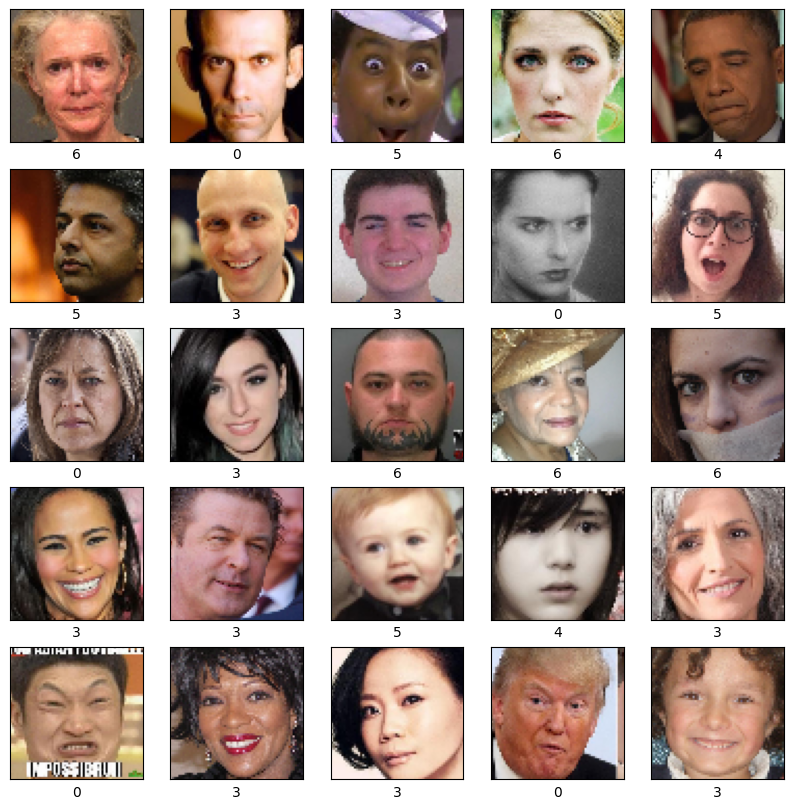

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_float32 = np.float32(train_images[i])
    plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB) )
    # labels
    plt.xlabel( [k for k, v in label_dict.items() if v == train_l[i]][0] )
plt.show()

In [11]:
data.shape

(25000, 64, 64, 3)

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3))) # 3 é sobre RGB
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(80, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(40, kernel_size=(3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation='relu')) # Dense: Núm. neurônios 1a cam
model.add(layers.Dense(10, activation='relu')) # Dense: Núm. neurônios 1a cam
model.add(layers.Dense(num_classes, activation="softmax"))
# 64 -> 80 -> 40 -> 20 -> 10 -> 5
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 80)          │          46,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 80)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 40)          │          28,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │         115,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,277 (751.08 KB)

 Trainable params: 192,277 (751.08 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_l, epochs=30, batch_size=5,
                    validation_data=(test_images, test_l))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.2060 - loss: 1.6105 - val_accuracy: 0.2054 - val_loss: 1.6097
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.1963 - loss: 1.6099 - val_accuracy: 0.1994 - val_loss: 1.6095
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.1928 - loss: 1.6098 - val_accuracy: 0.1994 - val_loss: 1.6097
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.2060 - loss: 1.6097 - val_accuracy: 0.2038 - val_loss: 1.6094
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.1931 - loss: 1.6097 - val_accuracy: 0.1928 - val_loss: 1.6095
Epoch 6/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.1967 - loss: 1.6097 - val_accuracy: 0.1986 - val_loss: 1.6098
Epoch 7/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.1989 - loss: 1.6096 - val_accuracy: 0.2054 - val_loss: 1.6094
Epoch 8/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.1991 - loss: 1.6098 - val

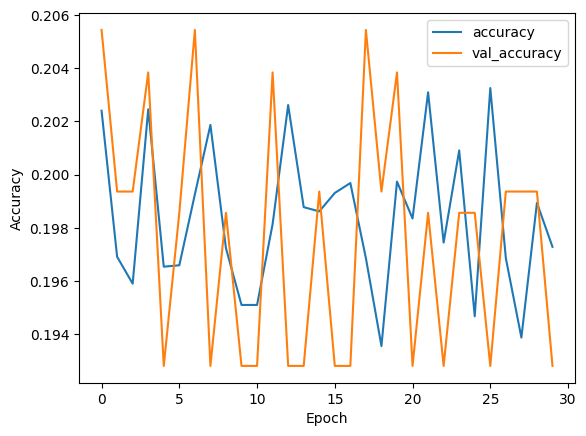

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [15]:
print("Generating test predictions...")
predict_x=model.predict(test_images)
print(np.around(predict_x, 2))

# make class predictions
predictions = (predict_x > 0.5).astype(int)

y_pred_class = np.argmax(predictions, axis=1)
y_test_class = np.argmax(test_labels, axis=1)

for i in range(len(test_labels)):
	if y_pred_class[i] == y_test_class[i]:
		print(f'\033[92m {y_pred_class[i]} (expected {y_test_class[i]})')
	else:
		print(f'\033[91m {y_pred_class[i]} (expected {y_test_class[i]})')

A saída de streaming foi truncada nas últimas 5000 linhas.
 0 (expected 3)
 0 (expected 3)
 0 (expected 3)
 0 (expected 4)
 0 (expected 3)
 0 (expected 0)
 0 (expected 2)
 0 (expected 4)
 0 (expected 4)
 0 (expected 4)
 0 (expected 3)
 0 (expected 0)
 0 (expected 3)
 0 (expected 0)
 0 (expected 0)
 0 (expected 4)
 0 (expected 1)
 0 (expected 4)
 0 (expected 3)
 0 (expected 4)
 0 (expected 3)
 0 (expected 0)
 0 (expected 3)
 0 (expected 3)
 0 (expected 0)
 0 (expected 4)
 0 (expected 4)
 0 (expected 3)
 0 (expected 2)
 0 (expected 2)
 0 (expected 1)
 0 (expected 4)
 0 (expected 0)
 0 (expected 2)
 0 (expected 2)
 0 (expected 1)
 0 (expected 2)
 0 (expected 4)
 0 (expected 4)
 0 (expected 1)
 0 (expected 2)
 0 (expected 1)
 0 (expected 0)
 0 (expected 3)
 0 (expected 1)
 0 (expected 3)
 0 (expected 4)
 0 (expected 0)
 0 (expected 4)
 0 (expected 4)
 0 (expected 2)
 0 (expected 3)
 0 (expected 4)
 0 (expected 0)
 0 (expected 2)
 0 (expected 2)
 0 (expected 4)
 0 (expected 4)
 0 (expected 

In [16]:
# Avaliando a acurácia com as imagens de Teste
l = len(y_test_class)
y_test2 = y_test_class
y_pred2 = y_pred_class
acc = sum([y_pred_class[i]==y_test_class[i] for i in range(l)])/l
print('Accuracy: %.2f %%' % (acc*100))

f1score = 0
f1score += f1_score(y_test2,y_pred2,average="weighted")
print("F_measure: ",round(100*f1score, 2),"%")
# Calcular com F_meansure


Accuracy: 19.86 %
F_measure:  6.58 %


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (4).

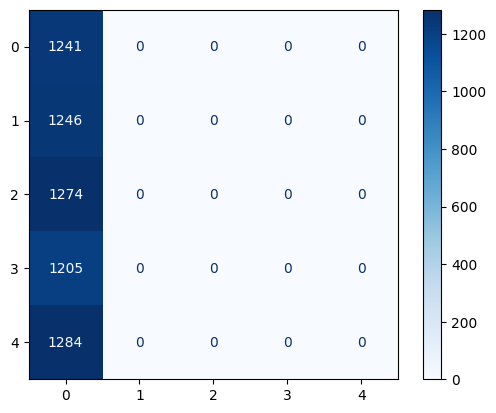

In [17]:
# voltando pro formato de classes
y_pred = np.argmax(predictions, axis=1)
y_test_c = np.argmax(test_labels, axis=1)


#Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=numtoemotion(label_dict))
disp.plot(cmap=plt.cm.Blues)


In [ ]:
model.save(r'./drive/MyDrive/ColabNotebooks/ProjetoVisaoComputacional/dice.hdf5')